In [11]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid
import pickle


In [3]:
df = pd.read_csv('A2457.txt', delim_whitespace=True, lineterminator='\n').drop('id', axis = 1)
df

,r,dr,g,dg,u,du,i,di,z,dz,zspec
0,20.8498,0.087124,20.8860,0.005956,19.9325,0.014263,20.0788,0.035860,19.8511,0.075540,2.505000
1,20.2984,0.046205,20.6447,0.004217,19.2952,0.008835,20.0889,0.034942,20.4333,0.078268,1.895000
2,20.8883,0.064217,21.7938,0.012222,22.1299,0.092288,20.5905,0.044032,20.0958,0.099445,3.405000
3,15.3928,0.001871,16.4288,0.000498,16.1900,0.002139,15.0507,0.001141,14.7237,0.002326,0.039055
4,21.1361,0.085443,21.3559,0.007474,20.6440,0.029433,20.8778,0.056025,21.2004,0.124193,2.365000
...,...,...,...,...,...,...,...,...,...,...,...
662,19.1186,0.027805,21.0347,0.013256,21.4664,0.091210,18.4442,0.011597,18.1855,0.023093,0.410812
663,19.6923,0.042599,21.9020,0.022806,22.8041,0.140533,18.8218,0.017058,18.7771,0.039564,0.499613
664,20.4720,0.058682,20.5128,0.003799,19.5003,0.009951,20.3356,0.046609,20.1929,0.103614,2.574073
665,20.4289,0.074319,22.5736,0.033274,22.4091,0.127780,19.6188,0.029984,19.3738,0.063926,0.689085


In [4]:
# some filtering of outliers based on what was seen in EDA

df_filt = df[df.dz<0.175]
df_filt = df_filt[df_filt.dr<0.14]
df_filt = df_filt[df_filt.dg<0.035]
df_filt = df_filt[df_filt.du<0.175]
df_filt = df_filt[df_filt.di<0.075]
df_filt = df_filt[df_filt.dz<0.175]
df_filt = df_filt[df_filt.zspec < 5]

df_filt

,r,dr,g,dg,u,du,i,di,z,dz,zspec
0,20.8498,0.087124,20.8860,0.005956,19.9325,0.014263,20.0788,0.035860,19.8511,0.075540,2.505000
1,20.2984,0.046205,20.6447,0.004217,19.2952,0.008835,20.0889,0.034942,20.4333,0.078268,1.895000
2,20.8883,0.064217,21.7938,0.012222,22.1299,0.092288,20.5905,0.044032,20.0958,0.099445,3.405000
3,15.3928,0.001871,16.4288,0.000498,16.1900,0.002139,15.0507,0.001141,14.7237,0.002326,0.039055
4,21.1361,0.085443,21.3559,0.007474,20.6440,0.029433,20.8778,0.056025,21.2004,0.124193,2.365000
...,...,...,...,...,...,...,...,...,...,...,...
662,19.1186,0.027805,21.0347,0.013256,21.4664,0.091210,18.4442,0.011597,18.1855,0.023093,0.410812
663,19.6923,0.042599,21.9020,0.022806,22.8041,0.140533,18.8218,0.017058,18.7771,0.039564,0.499613
664,20.4720,0.058682,20.5128,0.003799,19.5003,0.009951,20.3356,0.046609,20.1929,0.103614,2.574073
665,20.4289,0.074319,22.5736,0.033274,22.4091,0.127780,19.6188,0.029984,19.3738,0.063926,0.689085


In [7]:
X = df_filt.drop('zspec', axis = 1)
y = df_filt['zspec']

In [8]:
from sklearn.svm import SVR
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [15]:
# I should wrap this at some point in the future

prep = StandardScaler() # our features only require standard scaling

param_grid = {'C': [1,10,100,1000], 'gamma':[1e-5, 1e-3,1e-2, 1e0,1e2, 1e3, 1e5]}

# we see low end of gamma results in underfitting (high-bias); high gamma results in overfitting (high-variance)
# 0.01 clearly the sweet spot for our data
# C is less important here


bins = np.array([0.,1.,2.5,5.])        # define bins for stratification


nr_states = 10
test_scores = np.zeros(nr_states)
baseline_scores = np.zeros(nr_states)
X_tests = []
y_tests = []
final_models = []
y_preds = []



# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    y_binned = np.digitize(y, bins)       # bins to stratify on for the first split

    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify=y_binned, random_state=42*i)

    y_other_binned = np.digitize(y_other, bins)         #bins to stratify on for the second split
    
    X_tests.append(X_test)
    y_tests.append(y_test)

    
    # store the train and validation score for each parameter combination
    # the validation scores are necessary to select the best parameter combination
    # we also save the train score just to check things
    train_score_per_param = []
    val_score_per_param = []
    models = []

    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        #print('   ',params)          # uncomment to display parameters

        train_score_per_fold = []
        val_score_per_fold = []
        baseline_per_fold = []
        # second split to separate out the validation and test sets
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42*i)
        for train_idx, val_idx in kf.split(X_other,y_other_binned):
            X_train = X_other.iloc[train_idx]
            y_train = y_other.iloc[train_idx]
            X_val = X_other.iloc[val_idx]
            y_val = y_other.iloc[val_idx]

            # preprocess the sets
            X_train_prep = prep.fit_transform(X_train)
            X_val_prep = prep.transform(X_val)
            X_test_prep = prep.transform(X_test)

            mod = SVR(**params) # initialize the model
            mod.fit(X_train_prep,y_train) # fit the model

            # calculate train and validation MSE scores
            y_train_pred = mod.predict(X_train_prep)
            train_score = mean_squared_error(y_train,y_train_pred)
            train_score_per_fold.append(train_score)
            y_val_pred = mod.predict(X_val_prep)
            val_score = mean_squared_error(y_val,y_val_pred)
            val_score_per_fold.append(val_score)
            baseline_per_fold.append(mean_squared_error(y_test, [np.mean(y_train) for i in range(len(y_test))]))
            #print('   ',train_score,val_score)           # uncomment to see train score vs val score for each iteration
            
            
        meanfolds_train_score = np.mean(train_score_per_fold)        # calculate mean train score over the 4 folds
        meanfolds_val_score = np.mean(val_score_per_fold)            # calculate mean validation score over the 4 folds
        train_score_per_param.append(meanfolds_train_score)      # store the mean train score for this particular parameter combo
        val_score_per_param.append(meanfolds_val_score)          # store the mean val score for this particular parameter combo
        models.append(mod)                                       # keep track of which parameter combo this is
        
    # print out model parameters that minimize validation MSE score
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score_per_param)])
    print('corresponding validation score:',np.min(val_score_per_param))
    # collect and save the best model
    final_models.append(models[np.argmin(val_score_per_param)])
    # calculate and save the test score using best model
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = mean_squared_error(y_test,y_test_pred)
    # calculate and save baseline test score for comparison
    baseline_scores[i] = np.mean(baseline_per_fold)
    
    y_preds.append(y_test_pred)

    print('test score:',test_scores[i])
    print('baseline test score', baseline_scores[i])
    
print('\n')    
print('all test scores:', test_scores, '\n')
print('mean test score:', np.mean(test_scores))
print('SD of test scores:', np.std(test_scores))
print('mean baseline score', np.mean(baseline_scores))
print('SDs above baseline:', (np.mean(baseline_scores)-np.mean(test_scores))/np.std(test_scores))

file = open('results/svr.save', 'wb')
pickle.dump((final_models, X_tests, y_tests, y_preds, test_scores),file)
file.close()

randoms state 1
best model parameters: {'gamma': 0.01, 'C': 100}
corresponding validation score: 0.18106190667157077
test score: 0.17467959974478392
baseline test score 0.6760445949607834
randoms state 2
best model parameters: {'gamma': 0.01, 'C': 1000}
corresponding validation score: 0.16778540749717855
test score: 0.22942747357277668
baseline test score 0.6811861717394763
randoms state 3
best model parameters: {'gamma': 0.01, 'C': 1000}
corresponding validation score: 0.17019826096150342
test score: 0.20229676702827432
baseline test score 0.6506333041587445
randoms state 4
best model parameters: {'gamma': 0.01, 'C': 1000}
corresponding validation score: 0.17038558203853832
test score: 0.20191097736619878
baseline test score 0.7005768590877054
randoms state 5
best model parameters: {'gamma': 0.01, 'C': 1000}
corresponding validation score: 0.18048587808871164
test score: 0.13764355993483113
baseline test score 0.63633060675488
randoms state 6
best model parameters: {'gamma': 0.01, 'C'

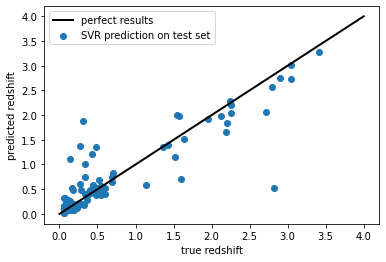

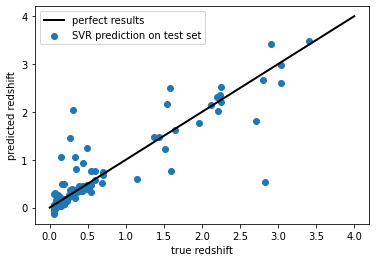

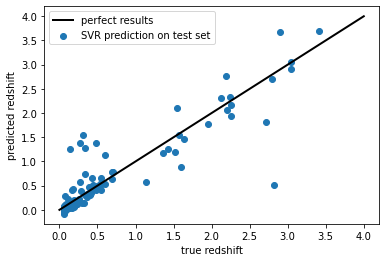

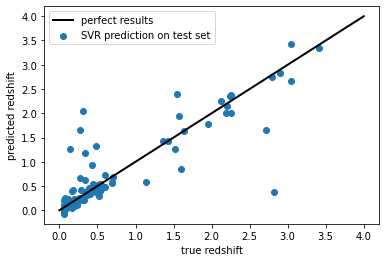

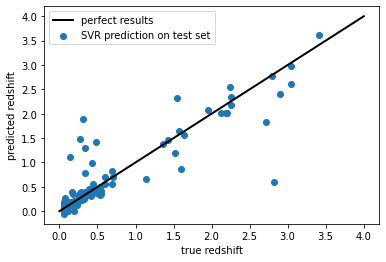

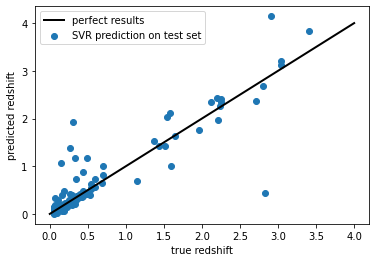

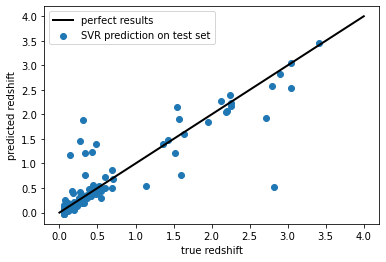

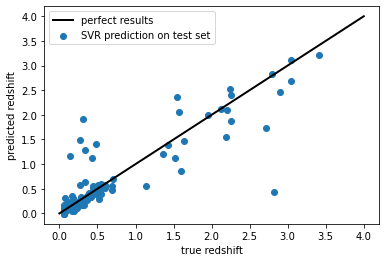

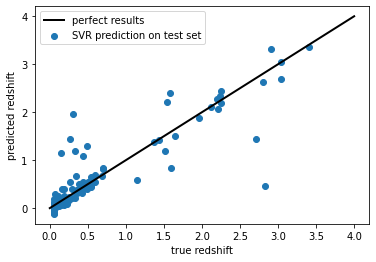

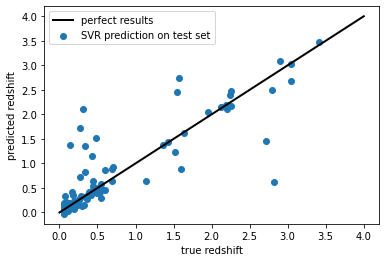

In [40]:
for i in range(len(final_models)):
    plt.scatter(y_test, final_models[i].predict(prep.transform(X_test)), label = 'SVR prediction on test set')
    plt.xlabel('true redshift')
    plt.ylabel('predicted redshift')
    plt.plot([0, 4], [0, 4], color = 'black', linewidth = 2, label = 'perfect results')
    plt.legend()
    plt.show()

In [27]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [28]:
# I should wrap this at some point in the future

prep = StandardScaler() # our features only require standard scaling

param_grid = {
              'max_depth': [1,3,5,10,30,50],
              'max_features': [0.5,0.6,0.7,0.8,0.9,1.0] # linearly spaced between 0.5 and 1
              } 


bins = np.array([0.,1.,2.5,5.])        # define bins for stratification


nr_states = 10
test_scores = np.zeros(nr_states)
baseline_scores = np.zeros(nr_states)
X_tests = []
y_tests = []
final_models = []
y_preds = []

# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    y_binned = np.digitize(y, bins)       # bins to stratify on for the first split

    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify=y_binned, random_state=42*i)

    y_other_binned = np.digitize(y_other, bins)         #bins to stratify on for the second split

    X_tests.append(X_test)
    y_tests.append(y_test)

    # store the train and validation score for each parameter combination
    # the validation scores are necessary to select the best parameter combination
    # we also save the train score just to check things
    train_score_per_param = []
    val_score_per_param = []
    models = []

    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        #print('   ',params)          # uncomment to display parameters

        train_score_per_fold = []
        val_score_per_fold = []
        baseline_per_fold = []
        # second split to separate out the validation and test sets
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42*i)
        for train_idx, val_idx in kf.split(X_other,y_other_binned):
            X_train = X_other.iloc[train_idx]
            y_train = y_other.iloc[train_idx]
            X_val = X_other.iloc[val_idx]
            y_val = y_other.iloc[val_idx]

            # preprocess the sets
            X_train_prep = prep.fit_transform(X_train)
            X_val_prep = prep.transform(X_val)
            X_test_prep = prep.transform(X_test)


            mod = RandomForestRegressor(**params,random_state = 42*i) # initialize the model
            mod.fit(X_train_prep,y_train) # fit the model

            # calculate train and validation MSE scores
            y_train_pred = mod.predict(X_train_prep)
            train_score = mean_squared_error(y_train,y_train_pred)
            train_score_per_fold.append(train_score)
            y_val_pred = mod.predict(X_val_prep)
            val_score = mean_squared_error(y_val,y_val_pred)
            val_score_per_fold.append(val_score)
            baseline_per_fold.append(mean_squared_error(y_test, [np.mean(y_train) for i in range(len(y_test))]))
            #print('   ',train_score,val_score)           # uncomment to see train score vs val score for each iteration
            
            
        meanfolds_train_score = np.mean(train_score_per_fold)        # calculate mean train score over the 4 folds
        meanfolds_val_score = np.mean(val_score_per_fold)            # calculate mean validation score over the 4 folds
        train_score_per_param.append(meanfolds_train_score)      # store the mean train score for this particular parameter combo
        val_score_per_param.append(meanfolds_val_score)          # store the mean val score for this particular parameter combo
        models.append(mod)                                       # keep track of which parameter combo this is
        
    # print out model parameters that minimize validation MSE score
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score_per_param)])
    print('corresponding validation score:',np.min(val_score_per_param))
    # collect and save the best model
    final_models.append(models[np.argmin(val_score_per_param)])
    # calculate and save the test score using best model
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = mean_squared_error(y_test,y_test_pred)
    # calculate and save baseline test score for comparison
    baseline_scores[i] = np.mean(baseline_per_fold)
    
    y_preds.append(y_test_pred)

    
    print('test score:',test_scores[i])
    print('baseline test score', baseline_scores[i])
    
    
print('\n')    
print('all test scores:', test_scores, '\n')
print('mean test score:', np.mean(test_scores))
print('SD of test scores:', np.std(test_scores))
print('mean baseline score', np.mean(baseline_scores))
print('SDs above baseline:', (np.mean(baseline_scores)-np.mean(test_scores))/np.std(test_scores))

file = open('results/randforest.save', 'wb')
pickle.dump((final_models, X_tests, y_tests, y_preds, test_scores),file)
file.close()

randoms state 1
best model parameters: {'max_features': 0.5, 'max_depth': 5}
corresponding validation score: 0.17685532528207773
test score: 0.18541216957487747
baseline test score 0.6760445949607834
randoms state 2
best model parameters: {'max_features': 0.6, 'max_depth': 10}
corresponding validation score: 0.16557804176187266
test score: 0.2473083239953049
baseline test score 0.6811861717394763
randoms state 3
best model parameters: {'max_features': 0.5, 'max_depth': 5}
corresponding validation score: 0.19688233929647042
test score: 0.15280737870093078
baseline test score 0.6506333041587445
randoms state 4
best model parameters: {'max_features': 0.7, 'max_depth': 5}
corresponding validation score: 0.2019251007604994
test score: 0.2043983259858836
baseline test score 0.7005768590877054
randoms state 5
best model parameters: {'max_features': 0.5, 'max_depth': 30}
corresponding validation score: 0.18349674947234212
test score: 0.2011493635347361
baseline test score 0.63633060675488
rand

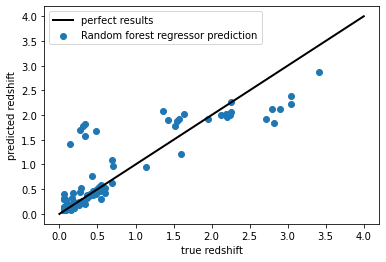

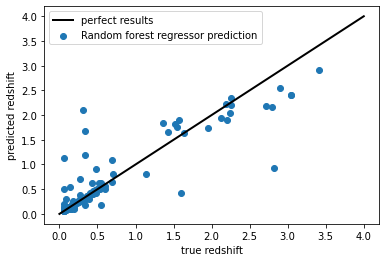

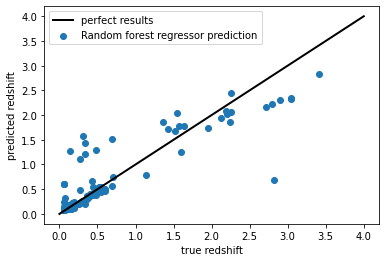

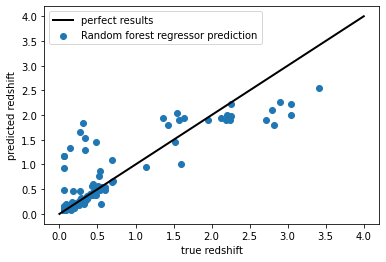

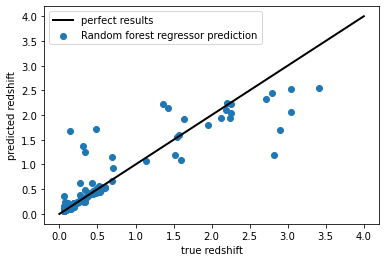

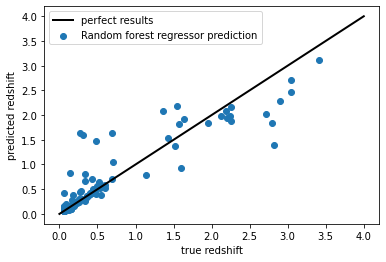

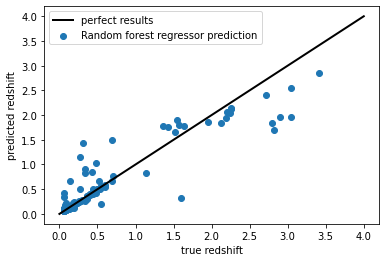

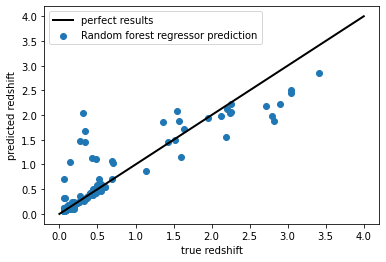

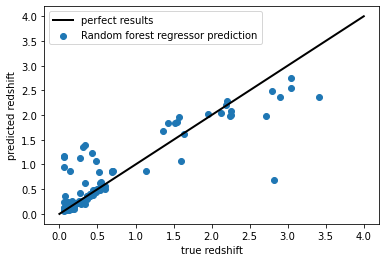

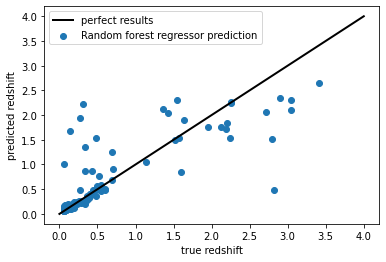

In [44]:
for i in range(len(final_models)):
    plt.scatter(y_test, final_models[i].predict(prep.transform(X_test)), label = 'Random forest regressor prediction')
    plt.xlabel('true redshift')
    plt.ylabel('predicted redshift')
    plt.plot([0, 4], [0, 4], color = 'black', linewidth = 2, label = 'perfect results')
    plt.legend()
    plt.show()

In [42]:
import xgboost

In [43]:
# I should wrap this at some point in the future

prep = StandardScaler() # our features only require standard scaling

param_grid = {"learning_rate": [0.03],
      "n_estimators": [1000],
      #"seed": [0],
      "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
      "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
      "max_depth": [1, 3, 5, 10, 30, 50],
      "colsample_bytree": [0.9],              
      "subsample": [0.66]}


bins = np.array([0.,1.,2.5,5.])        # define bins for stratification


nr_states = 10
test_scores = np.zeros(nr_states)
baseline_scores = np.zeros(nr_states)
X_tests = []
y_tests = []
final_models = []
y_preds = []


# loop through the different random states
for i in range(nr_states):
    print('randoms state '+str(i+1))

    y_binned = np.digitize(y, bins)       # bins to stratify on for the first split

    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size = 0.2, stratify=y_binned, random_state=42*i)

    y_other_binned = np.digitize(y_other, bins)         #bins to stratify on for the second split

    X_tests.append(X_test)
    y_tests.append(y_test)

    # store the train and validation score for each parameter combination
    # the validation scores are necessary to select the best parameter combination
    # we also save the train score just to check things
    train_score_per_param = []
    val_score_per_param = []
    models = []

    # loop through all combinations of hyperparameter combos
    for p in range(len(ParameterGrid(param_grid))):
        params = ParameterGrid(param_grid)[p]
        #print('   ',params)          # uncomment to display parameters

        train_score_per_fold = []
        val_score_per_fold = []
        baseline_per_fold = []
        # second split to separate out the validation and test sets
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=42*i)
        for train_idx, val_idx in kf.split(X_other,y_other_binned):
            X_train = X_other.iloc[train_idx]
            y_train = y_other.iloc[train_idx]
            X_val = X_other.iloc[val_idx]
            y_val = y_other.iloc[val_idx]

            # preprocess the sets
            X_train_prep = prep.fit_transform(X_train)
            X_val_prep = prep.transform(X_val)
            X_test_prep = prep.transform(X_test)


            mod = xgboost.XGBRegressor(**params) # initialize the model
            mod.fit(X_train_prep,y_train,early_stopping_rounds=50,eval_set=[(X_val_prep, y_val)], verbose=False) # fit the model

            # calculate train and validation MSE scores
            y_train_pred = mod.predict(X_train_prep)
            train_score = mean_squared_error(y_train,y_train_pred)
            train_score_per_fold.append(train_score)
            y_val_pred = mod.predict(X_val_prep)
            val_score = mean_squared_error(y_val,y_val_pred)
            val_score_per_fold.append(val_score)
            baseline_per_fold.append(mean_squared_error(y_test, [np.mean(y_train) for i in range(len(y_test))]))
            #print('   ',train_score,val_score)           # uncomment to see train score vs val score for each iteration
            
            
        meanfolds_train_score = np.mean(train_score_per_fold)        # calculate mean train score over the 4 folds
        meanfolds_val_score = np.mean(val_score_per_fold)            # calculate mean validation score over the 4 folds
        train_score_per_param.append(meanfolds_train_score)      # store the mean train score for this particular parameter combo
        val_score_per_param.append(meanfolds_val_score)          # store the mean val score for this particular parameter combo
        models.append(mod)                                       # keep track of which parameter combo this is
        
    # print out model parameters that minimize validation MSE score
    print('best model parameters:',ParameterGrid(param_grid)[np.argmin(val_score_per_param)])
    print('corresponding validation score:',np.min(val_score_per_param))
    # collect and save the best model
    final_models.append(models[np.argmin(val_score_per_param)])
    # calculate and save the test score using best model
    y_test_pred = final_models[-1].predict(X_test_prep)
    test_scores[i] = mean_squared_error(y_test,y_test_pred)
    # calculate and save baseline test score for comparison
    baseline_scores[i] = np.mean(baseline_per_fold)
    
    y_preds.append(y_test_pred)
    
    print('test score:',test_scores[i])
    print('baseline test score', baseline_scores[i])
    
print('\n')    
print('all test scores:', test_scores, '\n')
print('mean test score:', np.mean(test_scores))
print('SD of test scores:', np.std(test_scores))
print('mean baseline score', np.mean(baseline_scores))
print('SDs above baseline:', (np.mean(baseline_scores)-np.mean(test_scores))/np.std(test_scores))

file = open('results/xgb.save', 'wb')
pickle.dump((final_models, X_tests, y_tests, y_preds, test_scores),file)
file.close()

randoms state 1
best model parameters: {'subsample': 0.66, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
corresponding validation score: 0.1808327603091644
test score: 0.21817083429779408
baseline test score 0.6760445949607834
randoms state 2
best model parameters: {'subsample': 0.66, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
corresponding validation score: 0.173679258277386
test score: 0.26560779978766735
baseline test score 0.6811861717394763
randoms state 3
best model parameters: {'subsample': 0.66, 'reg_lambda': 0.01, 'reg_alpha': 1.0, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
corresponding validation score: 0.18677493387239452
test score: 0.14971421422096212
baseline test score 0.6506333041587445
randoms state 4
best model parameters: {'subsample': 0.66, 'reg_lambda': 10.0, 'reg_a

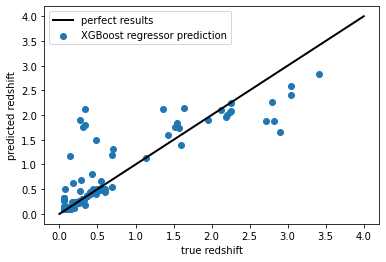

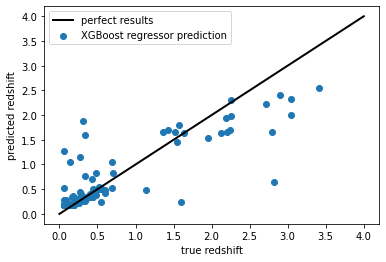

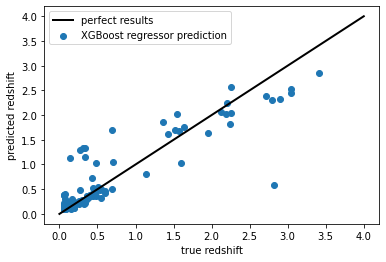

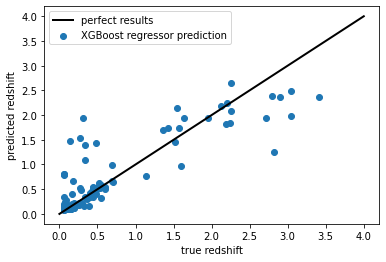

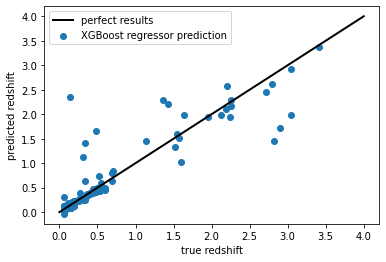

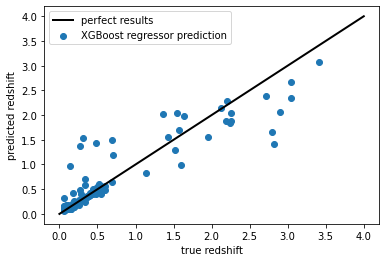

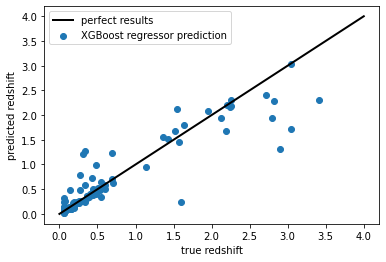

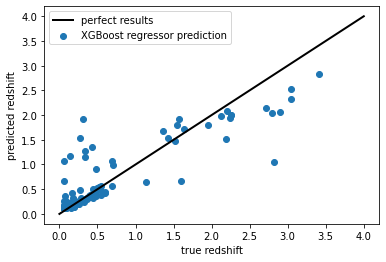

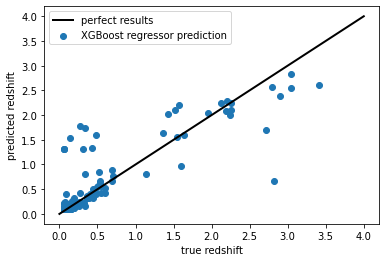

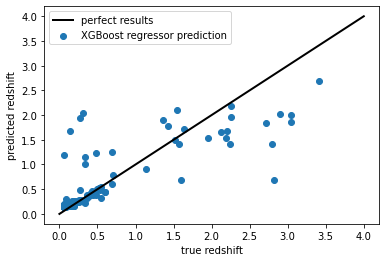

In [47]:
for i in range(len(final_models)):
    plt.scatter(y_test, final_models[i].predict(prep.transform(X_test)), label = 'XGBoost regressor prediction')
    plt.xlabel('true redshift')
    plt.ylabel('predicted redshift')
    plt.plot([0, 4], [0, 4], color = 'black', linewidth = 2, label = 'perfect results')
    plt.legend()
    plt.show()

test score =  0.20191097736619878
shuffling r
   shuffled test score: 1.135 +/- 0.124
shuffling dr
   shuffled test score: 0.256 +/- 0.017
shuffling g
   shuffled test score: 1.435 +/- 0.153
shuffling dg
   shuffled test score: 2.063 +/- 0.279
shuffling u
   shuffled test score: 1.09 +/- 0.162
shuffling du
   shuffled test score: 0.852 +/- 0.088
shuffling i
   shuffled test score: 0.267 +/- 0.024
shuffling di
   shuffled test score: 0.347 +/- 0.057
shuffling z
   shuffled test score: 0.321 +/- 0.027
shuffling dz
   shuffled test score: 0.445 +/- 0.07


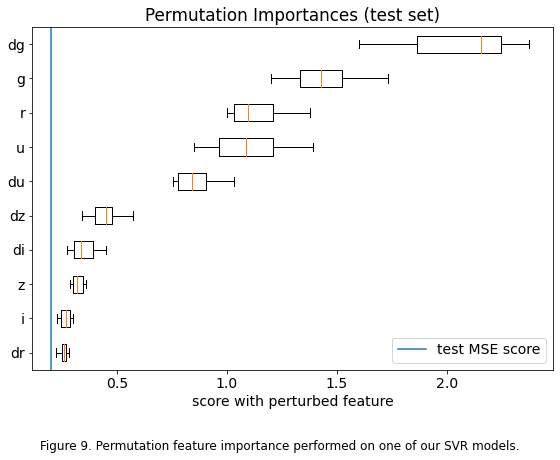

In [10]:
#Permutation feature importance

np.random.seed(42)

ftr_names = X.columns
nr_runs = 10

scores = np.zeros([len(ftr_names),nr_runs])

test_sc = test_scores[3]
baseline_sc = baseline_scores[3]

print('test score = ',test_sc)
#print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    mse_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)

        X_test_shuffled_prep = prep.transform(X_test_shuffled)

        y_test_shuffled_pred = final_models[3].predict(X_test_shuffled_prep)
        test_score = mean_squared_error(y_test,y_test_shuffled_pred)


        mse_scores.append(test_score)
    print('   shuffled test score:',np.around(np.mean(mse_scores),3),'+/-',np.around(np.std(mse_scores),3))
    scores[i] = mse_scores

import matplotlib.pylab as plt

sorted_indcs = np.argsort(np.mean(scores,axis=1))
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,6))
plt.boxplot(scores[sorted_indcs].T,labels=X_test_shuffled.columns[sorted_indcs],vert=False)
plt.axvline(test_sc,label='test MSE score')
plt.title("Permutation Importances (test set)")
text = ('Figure 9. Permutation feature importance performed on one of our SVR models.')
plt.figtext(0.5, -0.06, text, wrap=True, horizontalalignment='center', fontsize=12)
plt.legend(loc=2, prop={'size': 10})
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()